In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
customer_data = pd.read_csv('customer_gmm.csv')
display(customer_data)
customer_data = (np.array(customer_data))[:, 1:]
# print(customer_data)
# print(customer_data.shape)
scaler = StandardScaler()
scaler.fit(customer_data)
customer_data = scaler.transform(customer_data)
# print(customer_data)
# print(customer_data.shape)

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


# Implementation of Guassian Mixture Models in Python

In [15]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

class GMM:
    def __init__(self, n_components, iterations=100, threshold=0.004, min_covar=1e-6,seed=64):
        self.n_components = n_components
        self.means_ = None
        self.covariances_ = None
        self.prior_ = None
        self.wij = None
        self.iterations = iterations
        self.threshold = threshold
        self.converged = False
        self.log_likelihood_trace = []
        self.min_covar = min_covar
        self.seed = seed

    def initialize_parameters(self, data):
        n_samples, n_features = data.shape
        self.wij = np.zeros((n_samples, self.n_components))
        np.random.seed(self.seed)
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = data[chosen]
        self.prior_ = np.full(self.n_components, 1 / self.n_components)
        self.covariances_ = np.tile(np.identity(n_features), (self.n_components, 1, 1))
        return self.means_, self.covariances_, self.prior_

    def fit(self, data):
        means_, covariances_, prior_ = self.initialize_parameters(data)
        log_likelihood = 0
        for _ in range(self.iterations):
            new_log_likelihood = self.expectation_step(data)
            self.maximization_step(data)
            if abs(new_log_likelihood - log_likelihood) <= self.threshold:
                self.converged = True
                break
            log_likelihood = new_log_likelihood
            self.log_likelihood_trace.append(log_likelihood)
        return means_, covariances_, prior_

    def get_parameters(self):
        return self.means_, self.covariances_, self.prior_

    def expectation_step(self, X):
        for component in range(self.n_components):
            self.wij[:, component] = self.prior_[component] * multivariate_normal(self.means_[component], self.covariances_[component]).pdf(X)
        epsilon = 1e-16
        log_likelihood = np.sum(np.log(np.sum(self.wij, axis=1) + epsilon))
        self.wij = self.wij / (self.wij.sum(axis=1, keepdims=1) + epsilon)
        return log_likelihood

    def maximization_step(self, X):
        responsibility_weight_sum = self.wij.sum(axis=0)
        self.prior_ = responsibility_weight_sum / X.shape[0]
        self.means_ = np.dot(self.wij.T, X) / responsibility_weight_sum.reshape(-1, 1)
        for component in range(self.n_components):
            self.covariances_[component] = np.dot(self.wij[:, component] * (X - self.means_[component]).T, (X - self.means_[component])) / responsibility_weight_sum[component]
            self.covariances_[component] += self.min_covar * np.identity(X.shape[1])

    def predict(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        return np.argmax(log_likelihood, axis=1)
    
    def calculate_log_likelihood(self, X):
        n_samples = X.shape[0]
        n_components = self.n_components
        log_likelihood = np.zeros((n_samples, n_components))

        for k in range(n_components):
            prior = self.prior_[k]
            likelihood = multivariate_normal.pdf(X, self.means_[k], self.covariances_[k], allow_singular=True)
            log_likelihood[:, k] = np.log(prior * likelihood)

        return log_likelihood

    def aic(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        n_samples, n_features = X.shape
        n_params = self.n_components * (n_features + 1) + self.n_components * n_features * (n_features + 1) // 2
        aic = -2 * np.sum(log_likelihood) + 2 * n_params
        return aic

    def bic(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        n_samples, n_features = X.shape
        n_params = self.n_components * (n_features + 1) + self.n_components * n_features * (n_features + 1) // 2
        bic = -2 * np.sum(log_likelihood) + n_params * np.log(n_samples)
        return bic

    def silhouette_score(self, X):
        log_likelihood = self.calculate_log_likelihood(X)
        cluster_labels = np.argmax(log_likelihood, axis=1)
        return silhouette_score(X, cluster_labels)


64
[-25377.856210011592, -16155.590732523004, -13486.985445197994, -7166.485064197043, -3303.545996153274, 1695.0774674889453, 2992.5919691172717]


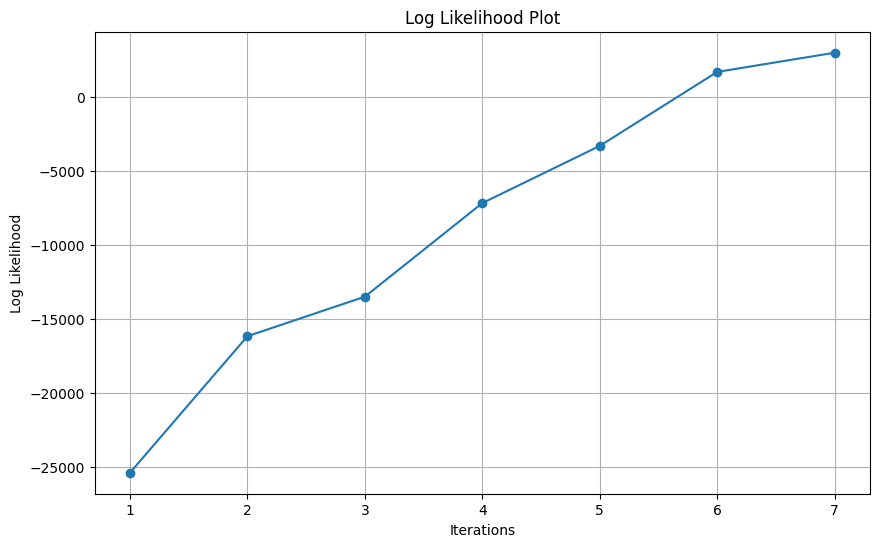

True
Custom GMM Means:
[[-0.91739884 -0.51971628  0.16777833 -0.2246138   0.17902703  0.18576512
   0.27595648]
 [ 1.09003844  1.00702467 -0.23181596  0.37394444 -0.11843403 -0.10753322
  -0.20891344]
 [ 1.09003844 -0.99302433 -0.06511624 -0.17580133 -0.60256172 -0.68874452
  -0.81982299]]
Scikit-learn GMM Means:
[[-0.91739884 -0.51971623  0.1677783  -0.22461369  0.1790271   0.18576517
   0.27595652]
 [ 1.09003844  1.00702467 -0.23181596  0.37394444 -0.11843403 -0.10753322
  -0.20891344]
 [ 1.09003844 -0.99302433 -0.06511624 -0.17580133 -0.60256172 -0.68874452
  -0.81982299]]

Custom GMM Covariances:
[[[ 1.00000000e-06 -4.99931534e-29 -4.64890418e-32  1.10411474e-30
   -4.78837131e-30  1.85956167e-29 -9.69296522e-30]
  [-5.04057436e-29  7.22619785e-01 -1.57785782e-01  2.88238934e-01
   -5.96119615e-02  3.52477108e-03 -2.61494293e-02]
  [ 9.29780837e-32 -1.57785782e-01  9.70725300e-01  7.21761039e-01
    3.23408414e-01  9.68014475e-02  8.45567421e-02]
  [ 1.20871509e-30  2.88238934e-01 

In [24]:
gmm = GMM(n_components = 3,seed=64)
print(seed)
means_,covariances_,prior_ = gmm.fit(customer_data)
print(gmm.log_likelihood_trace)
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(gmm.log_likelihood_trace)+1), gmm.log_likelihood_trace, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Plot')
plt.grid(True)
plt.show()
sklearn_gmm = GaussianMixture(n_components=gmm.n_components, covariance_type='full', tol=gmm.threshold,means_init=means_,precisions_init=covariances_,weights_init=prior_)
sklearn_gmm.fit(customer_data)
print(gmm.converged)
# Compare the results
print("Custom GMM Means:")
print(gmm.means_)
print("Scikit-learn GMM Means:")
print(sklearn_gmm.means_)

print("\nCustom GMM Covariances:")
print(gmm.covariances_)
print("Scikit-learn GMM Covariances:")
print(sklearn_gmm.covariances_)

print("\nCustom GMM Priors:")
print(gmm.prior_)
print("Scikit-learn GMM Priors:")
print(sklearn_gmm.weights_)

# GMM on Wine Dataset

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Find the optimal number of clusters for GMM using BIC and AIC
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

optimal_n_components_bic = n_components_range[np.argmin(bic_scores)]
optimal_n_components_aic = n_components_range[np.argmin(aic_scores)]

# Fit GMM with optimal number of clusters
gmm = GaussianMixture(n_components=optimal_n_components_bic, random_state=0)
gmm_labels = gmm.fit_predict(X_pca)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_n_components_bic, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compute silhouette scores for GMM and K-Means
silhouette_gmm = silhouette_score(X_pca, gmm_labels)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title(f'GMM Clustering (Silhouette Score: {silhouette_gmm:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (Silhouette Score: {silhouette_kmeans:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Print results
print(f'Optimal Number of Clusters (BIC): {optimal_n_components_bic}')
print(f'Optimal Number of Clusters (AIC): {optimal_n_components_aic}')
print(f'Silhouette Score (GMM): {silhouette_gmm:.2f}')
print(f'Silhouette Score (K-Means): {silhouette_kmeans:.2f}')


NameError: name 'X_std' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GMM(n_components=n_components, iterations = 100, threshold = 1e-10)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))


optimal_n_components_bic = n_components_range[np.argmin(bic_scores)]
optimal_n_components_aic = n_components_range[np.argmin(aic_scores)]
print(optimal_n_components_bic)
print(optimal_n_components_aic)

# Fit GMM with optimal number of clusters
gmm = GMM(n_components=optimal_n_components_bic,iterations = 70, threshold = 1e-6)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)

print(gmm_labels)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_n_components_bic, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compute silhouette scores for GMM and K-Means
silhouette_gmm = silhouette_score(X_pca, gmm_labels)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title(f'GMM Clustering (Silhouette Score: {silhouette_gmm:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clustering (Silhouette Score: {silhouette_kmeans:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Print results
print(f'Optimal Number of Clusters (BIC): {optimal_n_components_bic}')
print(f'Optimal Number of Clusters (AIC): {optimal_n_components_aic}')
print(f'Silhouette Score (GMM): {silhouette_gmm:.2f}')
print(f'Silhouette Score (K-Means): {silhouette_kmeans:.2f}')


/tmp/ipykernel_8907/361588799.py:72: RuntimeWarning: divide by zero encountered in log
  log_likelihood[:, k] = np.log(prior * likelihood)


1
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/rohit172/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)